# Compare Spot Detection Approaches Across Assays

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import starfish
import starfish.data
from starfish.types import Axes

Define some accessory functions

In [2]:
def count_genes(intensity_table):
    genes, counts = np.unique(intensity_table.target, return_counts=True)
    return pd.Series(counts, index=genes).drop('nan')

def compare_counts(a, b, ax):
    joined = pd.concat(dict(a=a, b=b), axis=1, sort=True).fillna(0)
    r, p = pearsonr(joined.a, joined.b)
    ax.scatter(joined.a, joined.b)
    ax.text(x=0.6, y=0.1, s=f"{r:.3f}", transform=ax.transAxes)
    
def vis_spots(spot_intensities, local_spot_intensities, pixel_intensities):
    spot_counts = count_genes(spot_intensities)
    local_spot_counts = count_genes(local_spot_intensities)
    pixel_spot_counts = count_genes(pixel_intensities)

    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, dpi=100, figsize=(9, 3))
    compare_counts(spot_counts, local_spot_counts, ax1)
    compare_counts(spot_counts, pixel_spot_counts, ax2)
    compare_counts(local_spot_counts, pixel_spot_counts, ax3)
    
def calculate_decoding_enrichment(intensity_table, codebook):
    n_codes, n_channels, n_rounds = codebook.shape
    possible_codes = n_channels ** n_rounds
    valid_code_space = n_codes / possible_codes
    fraction_decoded = float(np.sum(intensity_table.target != 'nan') / len(intensity_table))
    enrichment = float(fraction_decoded / valid_code_space)
    print(
        f"should decode by chance: {valid_code_space:.3f}\n"
        f"fraction that decodes: {fraction_decoded:.3f}\n"
        f"times enrichment: {enrichment:.3f}"
    )

Define the processing pipelines for each dataset

In [24]:
def process_iss():
    experiment = starfish.data.ISS()
    image = experiment.fov().get_image('primary')
    dots = experiment.fov().get_image('dots')

    filt = starfish.image.Filter.WhiteTophat(masking_radius=15, is_volume=False)
    image = filt.run(image)
    dots = filt.run(dots)

    learn_translation = starfish.image.LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
    transforms_list = learn_translation.run(image.max_proj(Axes.CH, Axes.ZPLANE))
    warp = starfish.image.ApplyTransform.Warp()
    image = warp.run(image, transforms_list=transforms_list)

    p = starfish.spots.DetectSpots.BlobDetector(
        min_sigma=1,
        max_sigma=10,
        num_sigma=30,
        threshold=0.01,
        measurement_type='mean',
    )
    spot_intensities = p.run(image, blobs_image=dots, blobs_axes=(Axes.ROUND, Axes.ZPLANE))

    blur = starfish.image.Filter.GaussianLowPass(sigma=1)
    blurred_image = blur.run(image)

    p = starfish.spots.DetectPixels.PixelSpotDecoder(
        metric='euclidean',
        codebook=experiment.codebook,
        distance_threshold=0.51,
        magnitude_threshold=0.01,
        min_area=5,
        max_area=40,
    )
    pixel_intensities, ccdr = p.run(blurred_image)

    p = starfish.spots.DetectSpots.LocalSearchBlobDetector(
        min_sigma=1,
        max_sigma=10,
        num_sigma=30,
        threshold=0.01,
        anchor_round=0,
        search_radius=2.45
    )
    local_spot_intensities = p.run(image)

    decoder = starfish.spots.Decode.PerRoundMaxChannel(experiment.codebook)
    spot_intensities = decoder.run(spot_intensities)
    local_spot_intensities = decoder.run(local_spot_intensities.fillna(0))
    
    vis_spots(spot_intensities, local_spot_intensities, pixel_intensities)
    
    calculate_decoding_enrichment(spot_intensities, experiment.codebook)
    
    return spot_intensities, local_spot_intensities, pixel_intensities

In [21]:
def process_starmap():
    experiment = starfish.data.STARmap(use_test_data=True)
    image = experiment.fov().get_image('primary')

    projection = image.max_proj(Axes.CH, Axes.ZPLANE)
    reference_image = projection.sel({Axes.ROUND: 1})

    mh = starfish.image.Filter.MatchHistograms({Axes.CH, Axes.ROUND})
    image = mh.run(image, n_processes=12)

    learn_translation = starfish.image.LearnTransform.Translation(reference_image, axes=Axes.ROUND, upsampling=1000)
    transforms_list = learn_translation.run(image.max_proj(Axes.CH, Axes.ZPLANE))
    warp = starfish.image.ApplyTransform.Warp()
    image = warp.run(image, transforms_list=transforms_list)

    threshold = np.percentile(np.ravel(image.xarray.values), 95)

    p = starfish.spots.DetectSpots.BlobDetector(
        min_sigma=1,
        max_sigma=8,
        num_sigma=10,
        threshold=threshold,
        measurement_type='mean',
        is_volume=True
    )
    spot_intensities = p.run(image, blobs_image=image, blobs_axes=(Axes.ROUND, Axes.CH))

    lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
        min_sigma=1,
        max_sigma=8,
        num_sigma=10,
        threshold=threshold,
        exclude_border=2,
        anchor_round=0,
        search_radius=10,
    )
    local_spot_intensities = lsbd.run(image, n_processes=8)

    image_2d = image.max_proj(Axes.ZPLANE)
    blur = starfish.image.Filter.GaussianLowPass(sigma=1)
    blurred_image = blur.run(image_2d)

    p = starfish.spots.DetectPixels.PixelSpotDecoder(
        metric='euclidean',
        codebook=experiment.codebook,
        distance_threshold=0.51,
        magnitude_threshold=0.01,
        min_area=5,
        max_area=40,
    )
    pixel_intensities, ccdr = p.run(blurred_image)

    decoder = starfish.spots.Decode.PerRoundMaxChannel(experiment.codebook)
    spot_intensities = decoder.run(spot_intensities)
    local_spot_intensities = decoder.run(local_spot_intensities.fillna(0))
    
    vis_spots(spot_intensities, local_spot_intensities, pixel_intensities)
    
    calculate_decoding_enrichment(spot_intensities, experiment.codebook)
    
    return spot_intensities, local_spot_intensities, pixel_intensities

In [22]:
def process_seqfish():
    # experiment = starfish.data.SeqFISH(use_test_data=True)
    experiment = starfish.Experiment.from_json('/Users/ajc/scratch/seqfish-test/experiment.json')
    image = experiment.fov().get_image('primary')

    wth = starfish.image.Filter.WhiteTophat(masking_radius=3)
    image = wth.run(image)

    def scale_by_percentile(data, p=99.9):
        data = np.asarray(data)
        cval = np.percentile(data, p)
        data = data / cval
        data[data > 1] = 1
        return data
    image = image.apply(scale_by_percentile, group_by={Axes.ROUND, Axes.CH}, n_processes=1)

    p = starfish.spots.DetectSpots.BlobDetector(
        min_sigma=0.9,
        max_sigma=5,
        num_sigma=7,
        threshold=0.1,
        measurement_type='mean',
    )
    spot_intensities = p.run(image, blobs_image=image, blobs_axes=(Axes.ROUND, Axes.CH))

    lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
        min_sigma=(0.9, 0.9, 0.9),
        max_sigma=(5, 5, 5),
        num_sigma=7,
        threshold=0.1,
        search_radius=2.45,
        exclude_border=2,
        anchor_round=0
    )
    local_spot_intensities = lsbd.run(image)

    # The pixel Spot Decoder isn't working; I think it finds 0 spots. 

    # image_2d = image.max_proj(Axes.ZPLANE)
    # glp = starfish.image.Filter.GaussianLowPass(sigma=1)
    # blurred = glp.run(image_2d)
    # psd = starfish.spots.DetectPixels.PixelSpotDecoder(
    #     codebook=experiment.codebook, 
    #     metric='euclidean', 
    #     distance_threshold=0,
    #     magnitude_threshold=0, 
    #     min_area=1, 
    #     max_area=50,
    # )
    # pixel_intensities, ccdr = psd.run(blurred)

    decoder = starfish.spots.Decode.PerRoundMaxChannel(experiment.codebook)
    spot_intensities = decoder.run(spot_intensities.fillna(0))
    local_spot_intensities = decoder.run(local_spot_intensities.fillna(0))

    spot_counts = count_genes(spot_intensities)
    local_spot_counts = count_genes(local_spot_intensities)
    f, ax = plt.subplots(dpi=100)
    compare_counts(spot_counts, local_spot_counts, ax)

    calculate_decoding_enrichment(spot_intensities, experiment.codebook)

    return spot_intensities, local_spot_intensities


100%|██████████| 16/16 [00:00<00:00, 42.99it/s]/Users/ajc/projects/spacetx/starfish/.venv/lib/python3.7/site-packages/slicedimage/_tile.py:36: UserWarning: Decoding tile just to obtain shape.  It is recommended to include the tile shape in the tileset document to avoid this.
  "Decoding tile just to obtain shape.  It is recommended to include the tile shape "

100%|██████████| 1688/1688 [00:05<00:00, 323.53it/s]

should decode by chance: 0.121
fraction that decodes: 0.590
times enrichment: 4.869


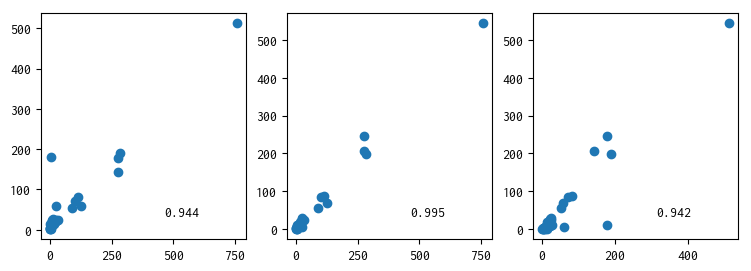

In [25]:
iss_results = process_iss()


100%|██████████| 2632/2632 [00:03<00:00, 784.43it/s]

should decode by chance: 0.039
fraction that decodes: 0.616
times enrichment: 15.761


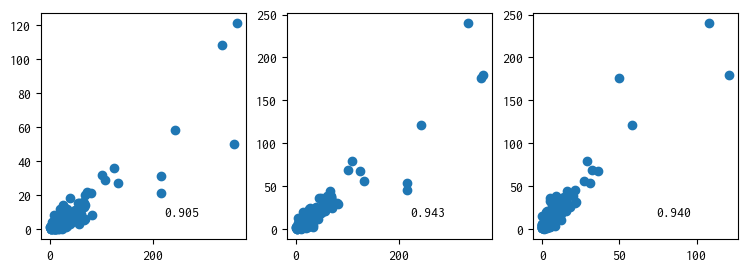

In [26]:
starmap_results = process_starmap()


100%|██████████| 29/29 [00:00<00:00, 263.16it/s]

should decode by chance: 0.042
fraction that decodes: 0.074
times enrichment: 1.761


NameError: name 'pixel_intensities' is not defined

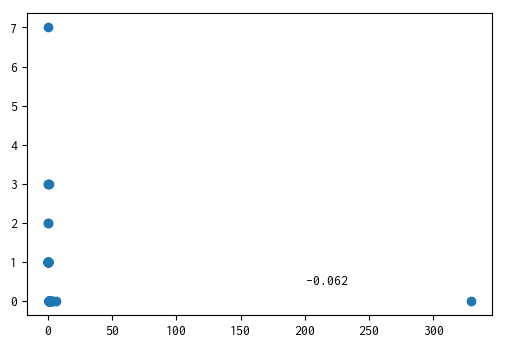

In [27]:
seqfish_results = process_seqfish()

In [ ]:
spot_counts, _ = seqfish_results

In [17]:
spot_counts.idxmax()

'Pom121l2'

In [14]:
experiment.codebook.sel(target="Pom121l2")

<xarray.Codebook (c: 12, r: 5)>
array([[0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)
Coordinates:
    target   <U8 'Pom121l2'
  * c        (c) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * r        (r) int64 0 1 2 3 4

Why this aberration occurs will be clear from the other SeqFISH notebook. 